In [1]:
# !pip install kmodes
# !pip install plotnine
# !pip install tabulate
# !pip install pandas_gbq 
# !pip install faiss

In [2]:
PROJECT='driven-insights' 

BUCKET='Carwash'
REGION='us-east1'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import date

### Importing Data

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

query = """

SELECT * 
FROM `driven-insights.steven_jordan.Member_Clustering_Customer_Level_v2`

"""

dataori = bq.query(query, location='US').to_dataframe()

In [5]:
data = dataori

In [6]:
df1 = data[[
    
    # 'customerid',
    'memberstatus',
    # 'memberoriginalstartdate',
    # 'memberstartdate',
    # 'firsttransaction',
    # 'MemberExpirationDate',
    # 'month',
    # 'lastrechargedate',
    # 'calcstart',
    # 'calclastrecharge',
    # 'calcexpiration',
    # 'spring',
    # 'summer',
    # 'fall',
    # 'winter',
    'membertenure',
    'repeatmember',
    # 'overlapmembership',
    # 'samedaypurchase',
    # 'MCC',
    # 'T5',
    # 'MAA',
    # 'revenue',
    # 'discounts',
    # 'recency',
    # 'frequency',
    # 'sitesvisited',
    'median_days_between_member_trips',
    # 'membersitename',
    # 'membersite',
    # 'mostvisited',
    # 'median_miles_to_site',
    # 'displaced_member',
    # 'acquisitionsource',
    # 'ConvertedMember',
    # 'CRM_Message_Count',
    # 'memberlastknownstatusdescription',
    # 'customercity',
    # 'customerstate',
    # 'customerpostal',
    # 'customerlatitude',
    # 'customerlongitude',
    # 'vehicleyear',
    # 'vehiclemake',
    # 'vehiclemodel',
    # 'lifestagecluster',
    # 'occupation',
    # 'race',
    # 'ownerrenter',
    # 'householdincome',
    # 'homemarketvalue',
    # 'generation',
    # 'birthyear',
    # 'maritalstatus',
    # 'gender',
    # 'education',
    # 'numberchildren',
    # 'phonecollected',
    # 'emailcollected',
    # 'addresscollected',
    'revenue_per_member_month',
    'frequency_per_member_month',
    'discounts_per_member_month'
    #'rownum'



]]

In [7]:
print(df1.shape)
df1.info()

(230124, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230124 entries, 0 to 230123
Data columns (total 7 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   memberstatus                      230124 non-null  object 
 1   membertenure                      230124 non-null  float64
 2   repeatmember                      230124 non-null  bool   
 3   median_days_between_member_trips  193974 non-null  float64
 4   revenue_per_member_month          230124 non-null  float64
 5   frequency_per_member_month        230124 non-null  float64
 6   discounts_per_member_month        89051 non-null   float64
dtypes: bool(1), float64(5), object(1)
memory usage: 10.8+ MB


In [8]:
#converting datatypes
df1 = df1.astype({"repeatmember": np.object})

### Seperating Numeric and Categorical Variables

In [9]:
# Get the position of categorical (without boolean) columns
catColumnsPosTEMP = [df1.columns.get_loc(col) for col in list(df1.select_dtypes('object').columns)]
print('Categorical(no Bool) columns           : {}'.format(list(df1.select_dtypes('object').columns)))
print('Categorical(no Bool) columns position  : {}'.format(catColumnsPosTEMP))

Categorical(no Bool) columns           : ['memberstatus', 'repeatmember']
Categorical(no Bool) columns position  : [0, 2]


In [10]:
# Get columns whose data type is numeric 
filteredColumns_num = df1.dtypes[df1.dtypes == np.float64]
# list of columns whose data type is numeric
listOfColumnNames = list(filteredColumns_num.index)
print(listOfColumnNames)
print(len(listOfColumnNames))

['membertenure', 'median_days_between_member_trips', 'revenue_per_member_month', 'frequency_per_member_month', 'discounts_per_member_month']
5


### Imputation

In [11]:
df1.isnull().sum()

memberstatus                             0
membertenure                             0
repeatmember                             0
median_days_between_member_trips     36150
revenue_per_member_month                 0
frequency_per_member_month               0
discounts_per_member_month          141073
dtype: int64

In [12]:
# Numeric variables imputation
df1["median_days_between_member_trips"].fillna(df1["median_days_between_member_trips"].max(), inplace = True)
# df1["revenue_per_member_month"].fillna(0, inplace = True)
df1["discounts_per_member_month"].fillna(0, inplace = True)

In [13]:
df1 = df1.dropna()

In [14]:
print(df1.shape)
df1.head()

(230124, 7)


,memberstatus,membertenure,repeatmember,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
0,Active Member,9.0,False,4.0,35.546667,6.222222,0.000000
1,Former Member,6.0,False,3.0,19.686667,3.500000,-1.166667
2,Former Member,7.0,False,6.0,27.854286,3.428571,0.000000
3,Former Member,9.0,True,11.0,6.664444,0.555556,-1.666667
4,Former Member,2.0,False,6.0,17.495000,5.000000,0.000000


In [15]:
df1.isnull().sum()

memberstatus                        0
membertenure                        0
repeatmember                        0
median_days_between_member_trips    0
revenue_per_member_month            0
frequency_per_member_month          0
discounts_per_member_month          0
dtype: int64

In [16]:
# df1.shape

In [17]:
# selecting the numeric variables out from DF for scaling
x = df1[['membertenure', 'median_days_between_member_trips', 'revenue_per_member_month', 'frequency_per_member_month', 'discounts_per_member_month']]
x.describe()

,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
count,230124.000000,230124.000000,230124.000000,230124.000000,230124.000000
mean,10.984161,181.319237,23.506149,2.417370,-2.924931
std,13.163238,393.435575,15.358962,2.887755,7.905769
min,1.000000,0.000000,-67.465000,0.011111,-111.980000
25%,2.000000,5.000000,13.330000,1.000000,-1.909091
50%,6.000000,9.000000,25.000000,1.708333,0.000000
75%,14.000000,20.000000,32.803125,3.000000,0.000000
max,309.000000,1091.000000,720.980000,130.000000,0.000000


### VIF

In [18]:
# run VIF for all the variables
dummies_col = pd.get_dummies(df1, drop_first=True, columns= ['memberstatus', 'repeatmember'])
dummies_col.head()
# VIF dataframe
vif_dummies = pd.DataFrame()
vif_dummies["feature"] = dummies_col.columns
  
# calculating VIF for each categorical feature
vif_dummies["VIF"] = [variance_inflation_factor(dummies_col.values, i)
                          for i in range(len(dummies_col.columns))]
  
print(vif_dummies)
# print(vif_dummies[vif_dummies["VIF"] > 5])

                            feature       VIF
0                      membertenure  1.710045
1  median_days_between_member_trips  1.211148
2          revenue_per_member_month  2.536755
3        frequency_per_member_month  1.916150
4        discounts_per_member_month  1.226548
5        memberstatus_Former Member  2.544720
6                 repeatmember_True  1.666387


### Scaling Numeric and Dummy Categorical Variables

In [19]:
# Normalize the variables to have mean=0 and sd=1
clusterdata=x.copy()
for i in range(clusterdata.shape[1]):
    clusterdata.iloc[:,i] = preprocessing.scale(clusterdata.iloc[:,i].astype('float64'))

In [20]:
clusterdata.describe()

,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
count,2.301240e+05,2.301240e+05,2.301240e+05,2.301240e+05,2.301240e+05
mean,1.921678e-15,2.859492e-15,-6.315782e-16,3.473485e-16,-2.369145e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-7.584898e-01,-4.608623e-01,-5.923014e+00,-8.332648e-01,-1.379440e+01
25%,-6.825205e-01,-4.481537e-01,-6.625559e-01,-4.908219e-01,1.284938e-01
50%,-3.786433e-01,-4.379869e-01,9.726268e-02,-2.455328e-01,3.699751e-01
75%,2.291112e-01,-4.100280e-01,6.053141e-01,2.017592e-01,3.699751e-01
max,2.264006e+01,2.312152e+00,4.541162e+01,4.418066e+01,3.699751e-01


In [21]:
clusterdata.shape

(230124, 5)

In [22]:
y = df1[['memberstatus', 'repeatmember']]

In [23]:
yd = pd.get_dummies(y, drop_first=True)

In [24]:
print(yd.shape)
yd.head()

(230124, 2)


,memberstatus_Former Member,repeatmember_True
0,0,0
1,1,0
2,1,0
3,1,1
4,1,0


In [25]:
# Combine scaled and dummied variables for a new df
df2 = pd.concat([clusterdata,yd], axis=1, join='inner')

In [26]:
print(df2.shape)
df2.head()

(230124, 7)


,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,memberstatus_Former Member,repeatmember_True
0,-0.150735,-0.450695,0.783943,1.317584,0.369975,0,0
1,-0.378643,-0.453237,-0.248682,0.374905,0.222403,1,0
2,-0.302674,-0.445612,0.283102,0.350169,0.369975,1,0
3,-0.150735,-0.432903,-1.096542,-0.644729,0.159158,1,1
4,-0.682521,-0.445612,-0.391378,0.894340,0.369975,1,0


### Elbow Method

In [27]:
from scipy.spatial.distance import cdist
clusters=range(1,11)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df2)
    clusassign=model.predict(df2)
    meandist.append(sum(np.min(cdist(df2, model.cluster_centers_, 'euclidean'), axis=1)) 
    / df2.shape[0])

In [28]:
cdist(df2, model.cluster_centers_, 'euclidean')

array([[ 1.53539456,  2.77681747,  3.84565439, ...,  3.65664367,
         9.83265135,  6.68498629],
       [ 1.04905526,  2.04457705,  3.05995007, ...,  3.16361776,
        10.98046712,  6.14338979],
       [ 0.68948063,  2.20393763,  3.20813853, ...,  3.12115166,
        10.48071745,  6.38650364],
       ...,
       [ 2.92037741,  3.56519301,  1.15810253, ...,  1.11506763,
        11.14333347,  6.56751351],
       [ 2.31418417,  3.04689283,  2.25698295, ...,  3.05959146,
        12.21552101,  6.39101892],
       [ 3.60937301,  3.99988766,  0.86012365, ...,  2.41048046,
        12.68869266,  6.54329372]])

In [29]:
df2.shape[0]

230124

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

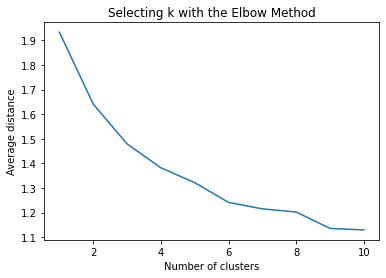

In [30]:
#plt.figure(figsize=(15,5))
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

In [31]:
# Define the model
kmeans_model_a = KMeans(n_clusters = 6, init='k-means++', random_state = 42)

# Fit into our dataset
kmeans_predict_a = kmeans_model_a.fit_predict(df2)

In [32]:
# The lowest SSE value
print(kmeans_model_a.inertia_)
# Final locations of the centroid
print(kmeans_model_a.cluster_centers_)
# The number of iterations required to converge
print(kmeans_model_a.n_iter_)

523844.73051140696
[[-0.56501749  2.31067383 -0.41916672 -0.62725614 -0.00574942  0.63499782
   0.03258116]
 [-0.7326517   0.225306   -0.93322904  0.24560275 -4.63523385  0.99881235
   0.07868171]
 [-0.20621451 -0.42831225 -0.66959705 -0.13170279  0.21826977  0.73088909
   0.29021082]
 [-0.20100157 -0.43008969  0.59449311  0.07199765  0.11652995  0.6635332
   0.23563965]
 [ 2.20255855 -0.41309512 -0.40923595 -0.2662458   0.30133375  0.5817921
   0.61583755]
 [-0.33484331 -0.44522481  1.08159788  3.40888023 -0.01704883  0.85260225
   0.37773838]]
43


In [33]:
df1['Cluster'] = kmeans_predict_a

In [34]:
df1

,memberstatus,membertenure,repeatmember,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,Cluster
0,Active Member,9.0,False,4.0,35.546667,6.222222,0.000000,3
1,Former Member,6.0,False,3.0,19.686667,3.500000,-1.166667,2
2,Former Member,7.0,False,6.0,27.854286,3.428571,0.000000,3
3,Former Member,9.0,True,11.0,6.664444,0.555556,-1.666667,2
4,Former Member,2.0,False,6.0,17.495000,5.000000,0.000000,2
...,...,...,...,...,...,...,...,...
230119,Former Member,1.0,False,2.0,0.010000,7.000000,0.000000,2
230120,Active Member,2.0,False,1091.0,22.495000,0.500000,0.000000,0
230121,Former Member,1.0,False,1091.0,25.000000,1.000000,0.000000,0
230122,Active Member,6.0,True,327.0,5.000000,0.333333,0.000000,2


### Prepare Exporting Data

In [35]:
data.shape

(230124, 62)

In [36]:
datana = data.dropna(axis=0, how='all', subset=["revenue_per_member_month","revenue_per_member_month"])

In [37]:
# swap the imputated columns
datana[["median_days_between_member_trips", "discounts_per_member_month"]] = df1[["median_days_between_member_trips", "discounts_per_member_month"]]

In [38]:
export = datana.iloc[:,0:61]

In [39]:
print(export.shape)
export.head()

(230124, 61)


,customerid,memberstatus,memberoriginalstartdate,memberstartdate,firsttransaction,MemberExpirationDate,month,lastrechargedate,calcstart,calclastrecharge,...,maritalstatus,gender,education,numberchildren,phonecollected,emailcollected,addresscollected,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
0,1000004044577,Active Member,2021-04-25,2021-04-25,2021-04-25,None,4,2021-12-19,2021-04-25,2021-12-19,...,Single,Male,None,Children,False,True,True,35.546667,6.222222,0.000000
1,1000004153591,Former Member,2020-10-22,2020-10-22,2020-10-22,2021-04-21,10,2021-03-22,2020-10-22,2021-03-22,...,Married,Male,Completed High School,Children,True,False,True,19.686667,3.500000,-1.166667
2,1000006951325,Former Member,2020-12-28,2020-12-28,2020-12-28,2021-04-28,12,2021-03-28,2020-12-28,2021-03-28,...,Single,Male,Completed College,Children,False,True,True,27.854286,3.428571,0.000000
3,1000008211622,Former Member,2020-08-13,2020-08-13,2020-08-13,2021-03-13,8,2021-02-13,2020-08-13,2021-02-13,...,Married,Female,Completed High School,Children,True,False,True,6.664444,0.555556,-1.666667
4,1000010257619,Former Member,2021-05-08,2021-05-08,2021-05-08,2021-07-08,5,2021-06-08,2021-05-08,2021-06-08,...,Married,None,None,Children,False,False,True,17.495000,5.000000,0.000000


In [40]:
export['Cluster'] = kmeans_predict_a
export['Cluster'] = export['Cluster'].replace(regex = {0 : "Discount Seekers", 1 : "Low Revenue", 2 : "High Tenure", 3 : "Discount Seekers", 4 : "Platinum Members", 5 : "High Frequency"})
export['RunDate'] = date.today()

In [41]:
print(export.shape)
export

(230124, 63)


,customerid,memberstatus,memberoriginalstartdate,memberstartdate,firsttransaction,MemberExpirationDate,month,lastrechargedate,calcstart,calclastrecharge,...,education,numberchildren,phonecollected,emailcollected,addresscollected,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,Cluster,RunDate
0,1000004044577,Active Member,2021-04-25,2021-04-25,2021-04-25,None,4,2021-12-19,2021-04-25,2021-12-19,...,None,Children,False,True,True,35.546667,6.222222,0.000000,Discount Seekers,2022-01-04
1,1000004153591,Former Member,2020-10-22,2020-10-22,2020-10-22,2021-04-21,10,2021-03-22,2020-10-22,2021-03-22,...,Completed High School,Children,True,False,True,19.686667,3.500000,-1.166667,High Tenure,2022-01-04
2,1000006951325,Former Member,2020-12-28,2020-12-28,2020-12-28,2021-04-28,12,2021-03-28,2020-12-28,2021-03-28,...,Completed College,Children,False,True,True,27.854286,3.428571,0.000000,Discount Seekers,2022-01-04
3,1000008211622,Former Member,2020-08-13,2020-08-13,2020-08-13,2021-03-13,8,2021-02-13,2020-08-13,2021-02-13,...,Completed High School,Children,True,False,True,6.664444,0.555556,-1.666667,High Tenure,2022-01-04
4,1000010257619,Former Member,2021-05-08,2021-05-08,2021-05-08,2021-07-08,5,2021-06-08,2021-05-08,2021-06-08,...,None,Children,False,False,True,17.495000,5.000000,0.000000,High Tenure,2022-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230119,1000022655157,Former Member,2021-11-05,2021-11-05,2021-11-05,2021-12-05,11,2021-11-05,2021-11-05,2021-11-05,...,None,Children,True,True,False,0.010000,7.000000,0.000000,High Tenure,2022-01-04
230120,1000022685251,Active Member,2021-11-27,2021-11-27,2021-11-27,None,11,2021-12-27,2021-11-27,2021-12-27,...,None,Children,False,False,False,22.495000,0.500000,0.000000,Discount Seekers,2022-01-04
230121,1000022783990,Former Member,2021-11-16,2021-11-16,2021-11-16,None,11,2021-11-16,2021-11-16,2021-11-16,...,Completed Graduate School,Children,True,True,True,25.000000,1.000000,0.000000,Discount Seekers,2022-01-04
230122,1000022943601,Active Member,2021-12-15,2021-12-15,2021-12-15,None,12,2021-12-15,2021-12-15,2021-12-15,...,None,Children,False,False,False,5.000000,0.333333,0.000000,High Tenure,2022-01-04


In [42]:
# change date to string for creating table in BigQuery
export[["RunDate", "memberoriginalstartdate", "memberstartdate", "firsttransaction", "MemberExpirationDate", "lastrechargedate", "calcstart", "calclastrecharge", "calcexpiration"]] = export[["RunDate", "memberoriginalstartdate", "memberstartdate", "firsttransaction", "MemberExpirationDate", "lastrechargedate", "calcstart", "calclastrecharge", "calcexpiration"]].astype('string')

In [ ]:
export = export_lastweek.append(export)

In [43]:
import pandas_gbq



export.to_gbq('tia_tsou.Member_Clustering_K-Means_test', 'driven-insights', if_exists='replace')

100% 1/1 [00:00<00:00, 4310.69it/s]


In [ ]:
#export.to_csv(r'Member_Clustering_K-Means_6_Clusters_12172021_.csv', header=True, index=False, encoding='utf-8')

In [42]:
export_lastweek = export